LangGraph requires `OPENAI_API_KEY`, so let's set it up

In [1]:
import os
os.environ['OPENAI_API_KEY']='sk-...'

Simplest LangGraph building blocks - nodes, edges and state

Let's define state, and then define the node - chatbot - that LangGraph uses

In [2]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langchain.chat_models import init_chat_model

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = init_chat_model("openai:gpt-4.1")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

We also need to connect nodes, such that LangGraph knows where to start, where to go and how to finish the graph

In [3]:
from langgraph.graph import START, END

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

How does the LangGraph look like right now?

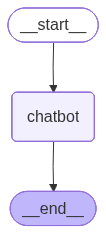

In [4]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [5]:
graph.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
 +---------+   
 | chatbot |   
 +---------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


Let's now define a method, that given user's input - runs LangGraph through our graph, and gives us output

In [6]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

stream_graph_updates('what is the capital of Argentina?')

Assistant: The capital of Argentina is **Buenos Aires**.


Right now, this is just a simple chatbot.

Let's introduce tools.

Here we're using LangChain community tools, specifically - WikiData tool (https://python.langchain.com/docs/integrations/tools/wikidata/)

In [7]:
from langchain_community.tools.wikidata.tool import WikidataAPIWrapper, WikidataQueryRun

wikidata_tool = WikidataQueryRun(api_wrapper=WikidataAPIWrapper())

print(wikidata_tool.run("Alan Turing"))

Result Q7251:
Label: Alan Turing
Description: English computer scientist (1912–1954)
Aliases: Alan M. Turing, Alan Mathieson Turing, Turing, Alan Mathison Turing
instance of: human
country of citizenship: United Kingdom
occupation: computer scientist, mathematician, university teacher, cryptographer, logician, statistician, marathon runner, artificial intelligence researcher
sex or gender: male
date of birth: 1912-06-23
date of death: 1954-06-07
sport: athletics
place of birth: Maida Vale, Warrington Lodge
educated at: King's College, Princeton University, Sherborne School, Hazlehurst Community Primary School
employer: Victoria University of Manchester, Government Communications Headquarters, University of Cambridge, National Physical Laboratory
place of death: Wilmslow
field of work: cryptanalysis, computer science, mathematics, logic, cryptography
cause of death: cyanide poisoning
notable work: On Computable Numbers, with an Application to the Entscheidungsproblem, Computing Machiner

Let's now update our LangGraph graph with tools.

First, we'll need to add a node for when LangGraph decides to use tools

LangGraph will decide to go to this node when it needs tools, and in the node we can pull out the tools that LangGraph needs, and run them.

In [ ]:
from langchain_core.messages import ToolMessage
import json

class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        print('calling basic tool node...')
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in inputs")
        outputs = []
        for tool_call in message.tool_calls:
            print(f'tool {tool_call} being processed...')
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

Now that we have the tool node, we need to:
1. Instantiate it and pass it list of tools
2. We need to update our chatbot. While we're already adding a tool node, we also need to let LLM know it can use tools
    2.1. For this, we need to redefine llm by binding tools to it (llm_with_tools = llm.bind_tools(tools))
    2.2. Once LLM is redefined, we need to update the node - chatbot - where this LLM is used

In [ ]:
tools = [wikidata_tool]
tool_node = BasicToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

Finally, let's plug tools into our LangGraph

1. We have defined our ToolNode, but we need to connect it to the graph via an edge

Let's define that edge. We're now introducing a different type of edge - conditional one.

It will need a function that will help it understand when to traverse this edge.

In [9]:
def route_tools(state: State):
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError("No messages found in inputs")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    return END

Now that we have all pieces, let's build our graph

In [10]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile()

Let's see how our graph looks now

Notice the new node for tools and conditional edge

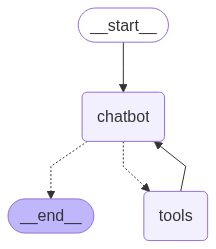

In [11]:
Image(graph.get_graph().draw_mermaid_png())

In [12]:
graph.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +---------+         
          | chatbot |         
          +---------+         
          .         *         
        ..           **       
       .               *      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


We've defined stream_graph_updates earlier to give an input to LangGraph and see the output.

Let's run it now with the new graph

In [13]:
stream_graph_updates("Alan Turing")

Assistant: 
calling basic tool node...
tool {'name': 'Wikidata', 'args': {'query': 'Alan Turing'}, 'id': 'call_y12UR0hsCRWhlrtXNlLISeAv', 'type': 'tool_call'} being processed...


Assistant: "Result Q7251:\nLabel: Alan Turing\nDescription: English computer scientist (1912\u20131954)\nAliases: Alan M. Turing, Alan Mathieson Turing, Turing, Alan Mathison Turing\ninstance of: human\ncountry of citizenship: United Kingdom\noccupation: computer scientist, mathematician, university teacher, cryptographer, logician, statistician, marathon runner, artificial intelligence researcher\nsex or gender: male\ndate of birth: 1912-06-23\ndate of death: 1954-06-07\nsport: athletics\nplace of birth: Maida Vale, Warrington Lodge\neducated at: King's College, Princeton University, Sherborne School, Hazlehurst Community Primary School\nemployer: Victoria University of Manchester, Government Communications Headquarters, University of Cambridge, National Physical Laboratory\nplace of death: Wilmslow\nfield of work: cryptanalysis, computer science, mathematics, logic, cryptography\ncause of death: cyanide poisoning\nnotable work: On Computable Numbers, with an Application to the Entsch

That’s awesome - we can now use tools in LangGraph!

But do we always need to write the graph ourselves?

No — LangGraph makes it easier by providing a prebuilt graph for agents + tools: create_react_agent!

In [14]:
from langgraph_cognee import add_tool, search_tool
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
        "openai:gpt-4o-mini",
        tools=[
            add_tool,
            search_tool,
        ],
    )
agent.step_timeout = None


2025-09-25T15:16:25.359928 [info     ] Deleted old log file: /Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/logs/2025-09-25_14-55-59.log [cognee.shared.logging_utils]

2025-09-25T15:16:25.611743 [info     ] Logging initialized            [cognee.shared.logging_utils] cognee_version=0.2.4 database_path=/Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases graph_database_name= os_info='Darwin 24.5.0 (Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:43 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8132)' python_version=3.12.7 relational_config=cognee_db structlog_version=25.4.0 vector_config=lancedb

2025-09-25T15:16:25.612145 [info     ] Database storage: /Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases [cognee.shared.logging_utils]


You can see in the diagram that it's essentially the same graph

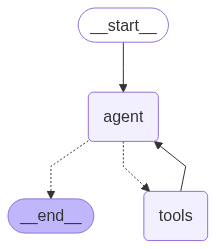

In [15]:
Image(agent.get_graph().draw_mermaid_png())

Now, cognee needs LLM_API_KEY, let's reuse OPENAI_API_KEY value

Also, let's run pruning - so that we know we're starting from a clean slate state

In [16]:
import cognee

os.environ['LLM_API_KEY']=os.environ['OPENAI_API_KEY']

await cognee.prune.prune_data()
await cognee.prune.prune_system(metadata=True)


2025-09-25T15:16:27.150479 [info     ] Deleted Kuzu database files at /Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases/cognee_graph_kuzu [cognee.shared.logging_utils]

2025-09-25T15:16:29.678041 [info     ] Database deleted successfully. [cognee.shared.logging_utils]


Let's give our agent a set of inputs that it can memorize in Cognee

1. LangGraph, having looked at our tool descriptions, will decide to store each input in Cognee using add_tool (see add_tool func for description). You can see this happening also by looking at logs
    > Adding data to cognee: Signed contract with Meditech Solutions in the healthcare industry. Start date: Jan 2023, End date: Dec 2025, Contract value: £1.2M.

In [17]:
from langchain_core.messages import HumanMessage

response = agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Meditech Solutions". Company is in the healthcare industry. Start date is Jan 2023 and end date is Dec 2025. Contract value is £1.2M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "QuantumSoft". Company is in the technology industry. Start date is Aug 2024 and end date is Aug 2028. Contract value is £5.5M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Orion Retail Group". Company is in the retail industry. Start date is Mar 2024 and end date is Mar 2026. Contract value is £850K.
            """
            ),
        ],
    }
)


print("=== FIRST RESPONSE ===")
print(response["messages"][-1].content)


Adding data to cognee: Signed contract with Meditech Solutions in the healthcare industry. Start date: Jan 2023, End date: Dec 2025, Contract value: £1.2M.

Adding data to cognee: Signed contract with Orion Retail Group in the retail industry. Start date: Mar 2024, End date: Mar 2026, Contract value: £850K.

Adding data to cognee: Signed contract with QuantumSoft in the technology industry. Start date: Aug 2024, End date: Aug 2028, Contract value: £5.5M.
Exception in thread Thread-10 (run_loop):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "

User 6626c9b7-3672-4e12-af53-4994a19168e4 has registered.



EmbeddingRateLimiter initialized: enabled=False, requests_limit=60, interval_seconds=60

2025-09-25T15:16:37.825361 [info     ] Pipeline run started: `7d468cdd-88fa-53a6-9a69-0377866bfa93` [run_tasks_with_telemetry()]

2025-09-25T15:16:37.825801 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:16:37.826127 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-09-25T15:16:37.840817 [info     ] Registered loader: pypdf_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-09-25T15:16:37.841219 [info     ] Registered loader: text_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-09-25T15:16:37.841474 [info     ] Registered loader: image_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-09-25T15:16:37.841723 [info     ] Registered loader: audio_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-09-25T15:16:37.841933 [info     ] Registered loader: unstructured_loader [cognee.infrastructure.loaders.L

=== FIRST RESPONSE ===
The contracts have been successfully recorded:

1. **Meditech Solutions**: Healthcare industry, Start date: Jan 2023, End date: Dec 2025, Contract value: £1.2M.
2. **QuantumSoft**: Technology industry, Start date: Aug 2024, End date: Aug 2028, Contract value: £5.5M.
3. **Orion Retail Group**: Retail industry, Start date: Mar 2024, End date: Mar 2026, Contract value: £850K.

If you need any further assistance or additional information, feel free to ask!


Cool!

Let's also add some data into our knowledge graph (secretly from LangGraph)

This is to later validate that LangGraph actually goes and uses data from Cognee store

In [18]:
agent.step_timeout = None

data_dir = os.path.join(os.getcwd(), "data")
for filename in os.listdir(data_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(data_dir, filename)
        with open(file_path, "r") as f:
            content = f.read()
            await cognee.add(content)
await cognee.cognify()


2025-09-25T15:16:57.097414 [info     ] Pipeline run started: `7d468cdd-88fa-53a6-9a69-0377866bfa93` [run_tasks_with_telemetry()]

2025-09-25T15:16:57.097884 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:16:57.098278 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-09-25T15:16:57.108266 [info     ] Coroutine task completed: `ingest_data` [run_tasks_base]

2025-09-25T15:16:57.108576 [info     ] Coroutine task completed: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:16:57.108826 [info     ] Pipeline run completed: `7d468cdd-88fa-53a6-9a69-0377866bfa93` [run_tasks_with_telemetry()]

2025-09-25T15:16:57.112443 [info     ] Model not found in LiteLLM's model_cost. [cognee.shared.logging_utils]

2025-09-25T15:16:57.112759 [info     ] Ontology file 'None' not found. No owl ontology will be attached to the graph. [OntologyAdapter]

2025-09-25T15:16:57.125262 [info     ] Pipeline run started: `0d4208f4-6663-5c6

{UUID('4a84d9b7-cb2e-5c9f-a885-a0d186fe7ce9'): PipelineRunCompleted(status='PipelineRunCompleted', pipeline_run_id=UUID('111c4f05-b335-5db7-8f7f-87a77ee1087e'), dataset_id=UUID('4a84d9b7-cb2e-5c9f-a885-a0d186fe7ce9'), dataset_name='main_dataset', payload=None, data_ingestion_info=[{'run_info': PipelineRunCompleted(status='PipelineRunCompleted', pipeline_run_id=UUID('111c4f05-b335-5db7-8f7f-87a77ee1087e'), dataset_id=UUID('4a84d9b7-cb2e-5c9f-a885-a0d186fe7ce9'), dataset_name='main_dataset', payload=None, data_ingestion_info=None), 'data_id': UUID('49f7b842-fd76-5fe2-852d-e5a84f459a41')}, {'run_info': PipelineRunAlreadyCompleted(status='PipelineRunAlreadyCompleted', pipeline_run_id=UUID('111c4f05-b335-5db7-8f7f-87a77ee1087e'), dataset_id=UUID('4a84d9b7-cb2e-5c9f-a885-a0d186fe7ce9'), dataset_name='main_dataset', payload=None, data_ingestion_info=None), 'data_id': UUID('8669c86d-8b39-5398-a5f2-0951b7b4d079')}, {'run_info': PipelineRunCompleted(status='PipelineRunCompleted', pipeline_run_id

Let's see how it looks after adding new data

I'm defining a function that uses cognee's graph visualization function, and opens it in your browser

In [ ]:
import webbrowser

async def visualize_graph(open_browser = True):
    destination_file_path = os.path.join(os.getcwd(), "graph_visualization.html")

    await cognee.visualize_graph(destination_file_path)

    if open_browser:
        url = "file://" + os.path.abspath(destination_file_path)
        webbrowser.open(url)

await visualize_graph()


2025-09-25T15:18:25.461314 [info     ] Graph visualization saved as /Users/daulet/Desktop/dev/langgraph-cognee/examples/graph_visualization.html [cognee.shared.logging_utils]

2025-09-25T15:18:25.461830 [info     ] The HTML file has been stored at path: /Users/daulet/Desktop/dev/langgraph-cognee/examples/graph_visualization.html [cognee.shared.logging_utils]


You can see clients.txt subgraph and input from LangGraph distinctly in the visualized graph below

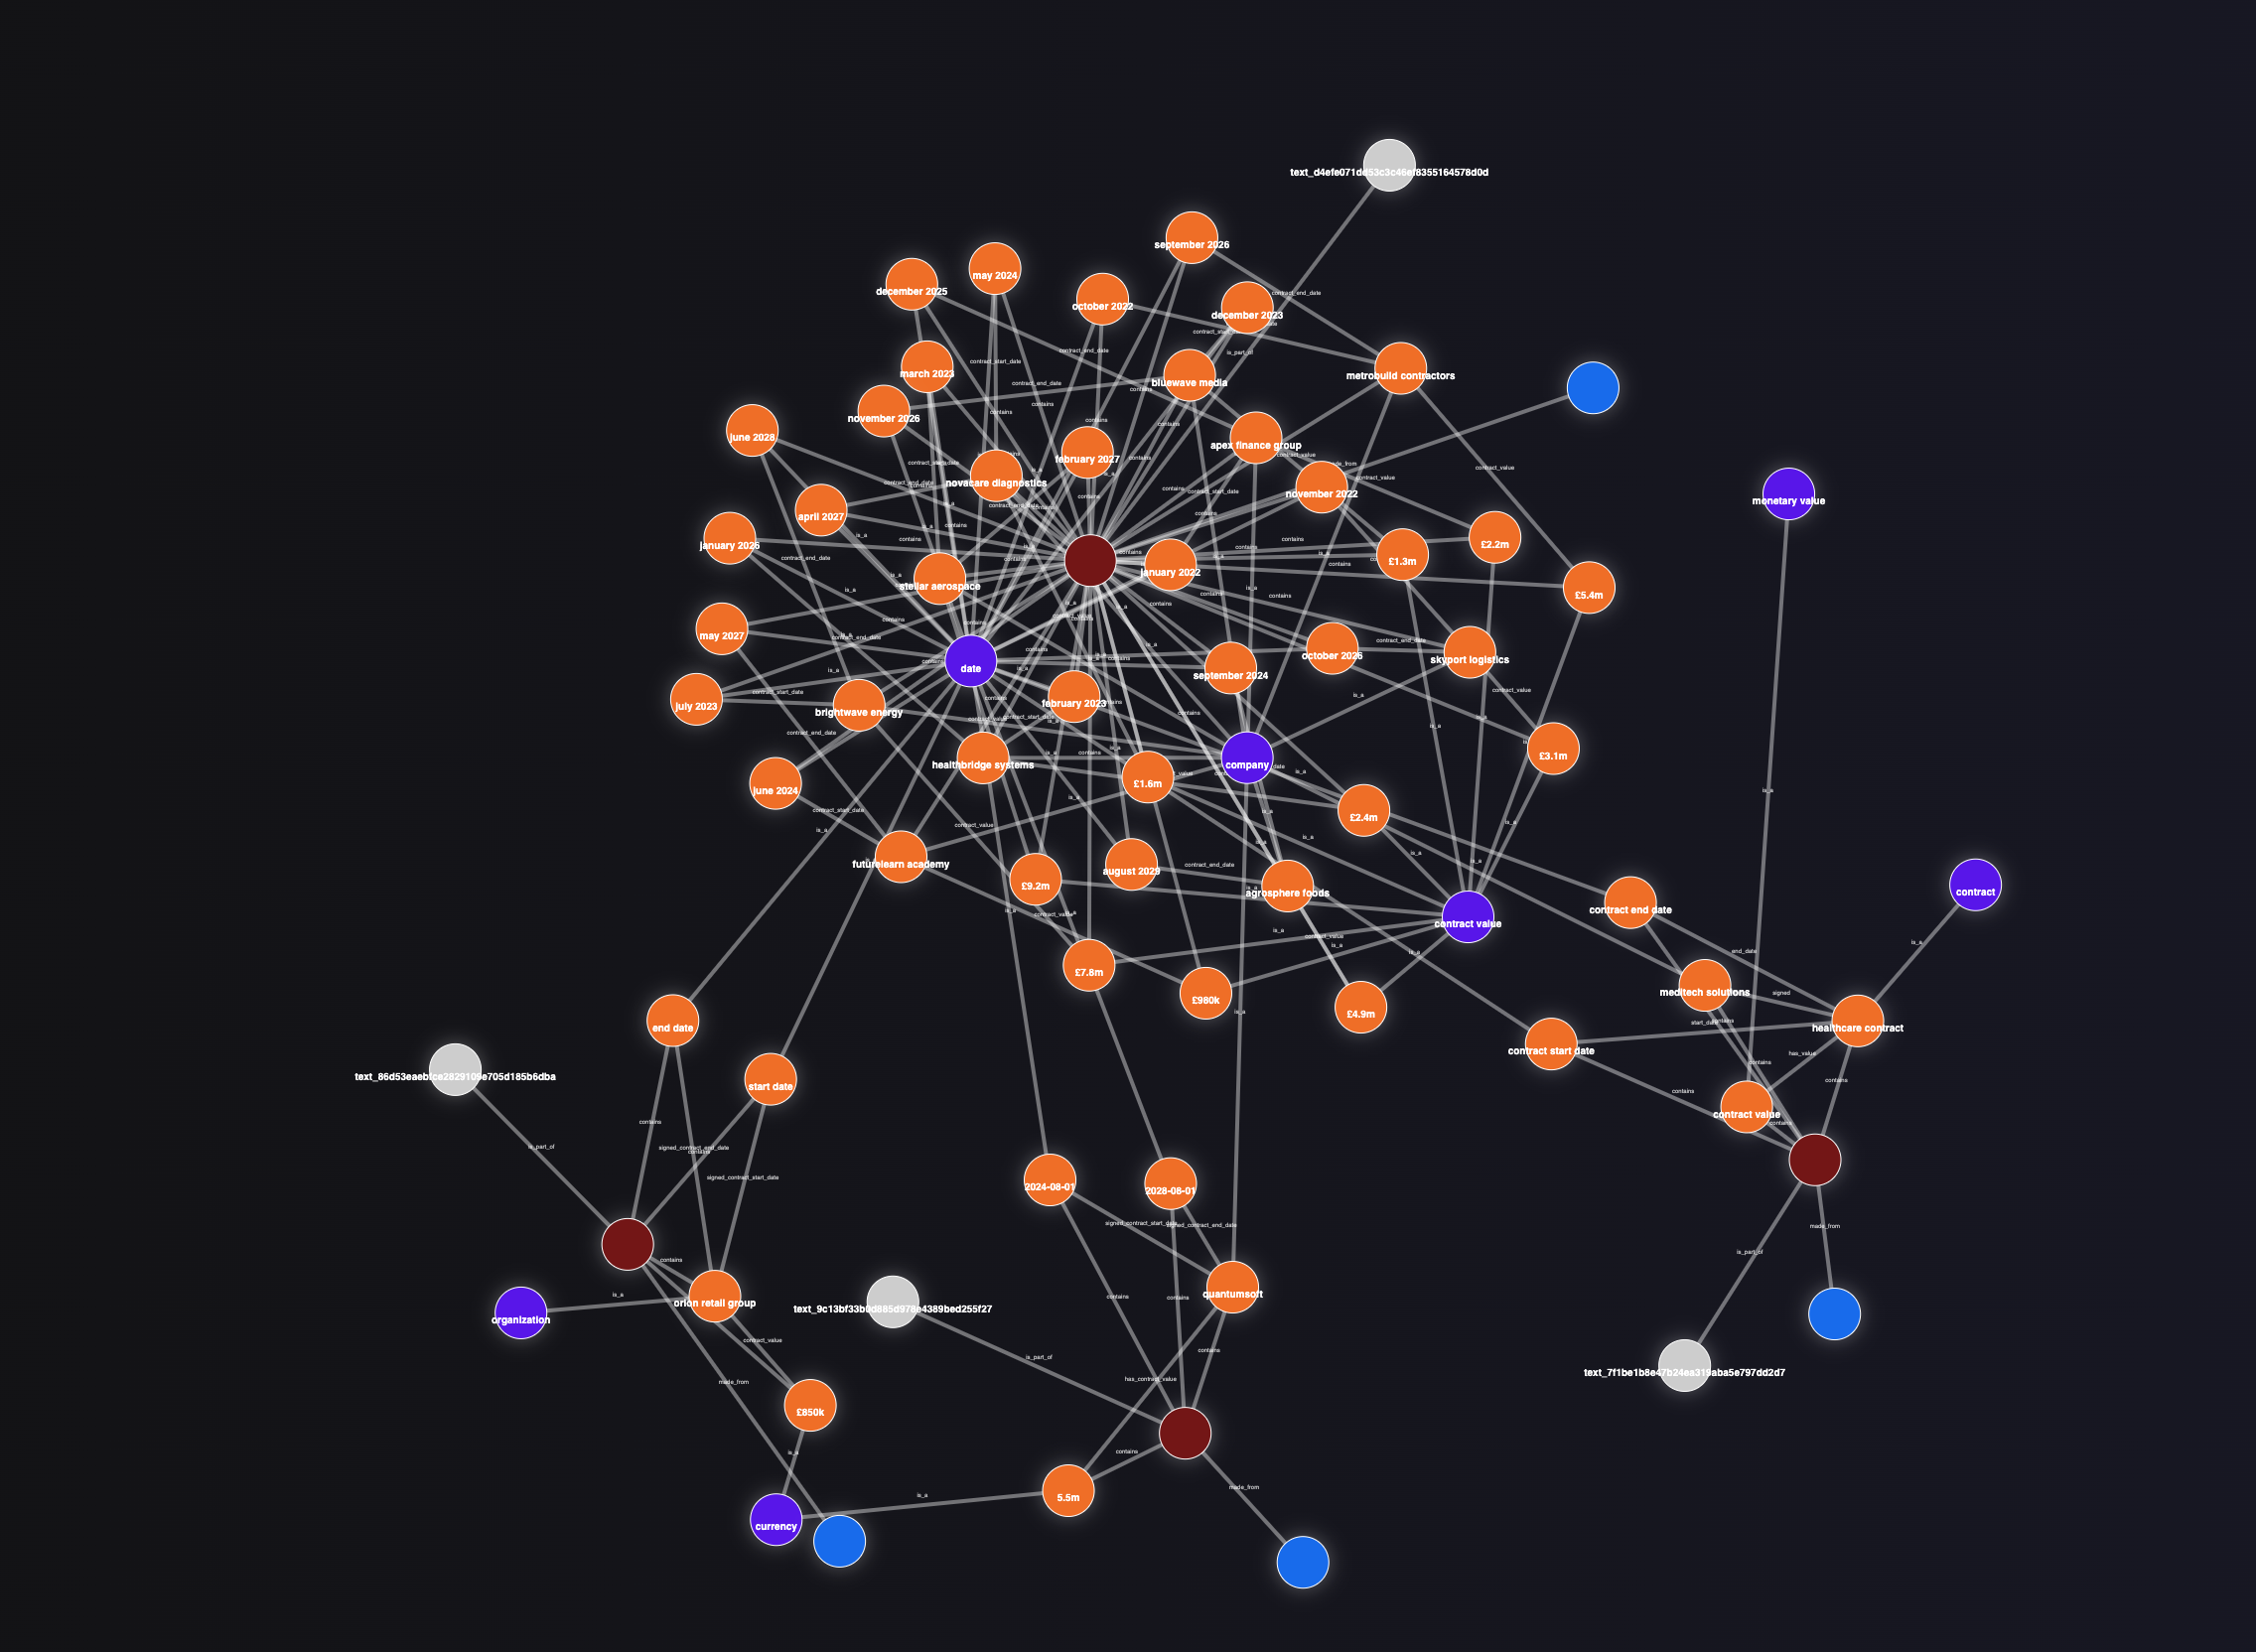

In [26]:
from IPython.display import Image, display

display(Image(filename="./images/first_graph_screenshot.png"))

Now, let's create a fresh new agent, to demonstrate that no state is carried over into a new agent

I.e. - it knows nothing we sent to previous agent

In [ ]:
# Create a fresh agent instance to avoid memory interference
fresh_agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=[
        add_tool,
        search_tool,
    ],
)
# Note: LangGraph by default can retry running tools if it considers it's running too long, so we're explicitly setting timeout to None so it doesn't retry
agent.step_timeout = None

response = fresh_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="I need to research our contract portfolio. Can you search for any contracts we have with companies in the healthcare industry? Please use the search functionality to find this information."
            ),
        ],
    }
)
print("\n=== SECOND RESPONSE ===")
print(response["messages"][-1].content)


Searching cognee for: contracts with companies in the healthcare industry

2025-09-25T15:18:26.677592 [info     ] Graph projection completed: 62 nodes, 127 edges in 0.00s [CogneeGraph]

2025-09-25T15:18:26.947839 [info     ] Vector collection retrieval completed: Retrieved distances from 6 collections in 0.04s [cognee.shared.logging_utils]

2025-09-25T15:18:26.951446 [info     ] Model not found in LiteLLM's model_cost. [cognee.shared.logging_utils]

Async operation completed successfully

Search results: ['Contracts with companies in the healthcare industry:\n1. HealthBridge Systems: Start date Feb 2023, End date Jan 2026, Contract value £2.4M.\n2. NovaCare Diagnostics: Start date May 2024, End date Apr 2027, Contract value £1.6M.\n3. Meditech Solutions: Start date Jan 2023, End date Dec 2025, Contract value £1.2M.']



=== SECOND RESPONSE ===
Here are the contracts we have with companies in the healthcare industry:

1. **HealthBridge Systems**
   - Start date: February 2023
   - End date: January 2026
   - Contract value: £2.4M

2. **NovaCare Diagnostics**
   - Start date: May 2024
   - End date: April 2027
   - Contract value: £1.6M

3. **Meditech Solutions**
   - Start date: January 2023
   - End date: December 2025
   - Contract value: £1.2M


Great!

These inputs to LangGraph and by extension Cognee look like they could benefit from additional metadata.

In [21]:
await cognee.prune.prune_data()
await cognee.prune.prune_system(metadata=True)


2025-09-25T15:18:33.838717 [info     ] Deleted Kuzu database files at /Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases/cognee_graph_kuzu [cognee.shared.logging_utils]

2025-09-25T15:18:35.877664 [info     ] Database deleted successfully. [cognee.shared.logging_utils]


Let's say we want to add our own, custom state into LangGraph.

There are two possible ways to consider:
1. Define a wrapper around `create_react_agent`
2. Define tools such that they know the state

Let's briefly explore two options.

1. create_react_agent

```python
agent = create_custom_agent(
    "openai:gpt-4o-mini",
    tools=[
        add_tool,
        search_tool,
    ],
)
```

A drawback is adding an extra layer around creating agent, which will make it unnecessarily more confusing.

2. Define tools such that they know the state

```python
def get_sessionized_cognee_tools(user_id: str) -> list:
    """
    Returns a list of cognee tools sessionized for a specific user.
    
    Args:
        user_id (str): The user session ID to bind to all tools
        
    Returns:
        list: List of sessionized cognee tools
    """
    session_decorator = sessionised_tool(user_id)
    
    sessionized_add_tool = tool(session_decorator(add_tool.func))
    sessionized_search_tool = tool(session_decorator(search_tool.func))
    
    return [
        sessionized_add_tool,
        sessionized_search_tool,
    ]
```

In [ ]:
from langgraph_cognee import get_sessionized_cognee_tools

add_tool, search_tool = get_sessionized_cognee_tools('cognee-test-user-1f5b133c-a98d-4448-9876-c31b8ba9b6e1')

super_fresh_agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=[
        add_tool,
        search_tool,
    ],
)

super_fresh_agent.step_timeout = None

response = super_fresh_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Guardian Insurance Ltd". Company is in the insurance industry. Start date is Feb 2023 and end date is Feb 2026. Contract value is £1.8M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Pioneer Assurance Group". Company is in the insurance industry. Start date is Oct 2024 and end date is Oct 2029. Contract value is £4.2M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Finovate Systems". Company is in the fintech industry. Start date is May 2024 and end date is May 2027. Contract value is £2.3M.
            """
            ),

        ],
    }
)

print("=== FIRST RESPONSE ===")
print(response["messages"][-1].content)


Using tool add_tool with user_id: cognee-test-user-1f5b133c-a98d-4448-9876-c31b8ba9b6e1

Using tool add_tool with user_id: cognee-test-user-1f5b133c-a98d-4448-9876-c31b8ba9b6e1

Adding data to cognee: Company: Guardian Insurance Ltd, Industry: Insurance, Start Date: Feb 2023, End Date: Feb 2026, Contract Value: £1.8M

Using tool add_tool with user_id: cognee-test-user-1f5b133c-a98d-4448-9876-c31b8ba9b6e1

Adding data to cognee: Company: Pioneer Assurance Group, Industry: Insurance, Start Date: Oct 2024, End Date: Oct 2029, Contract Value: £4.2M

Adding data to cognee: Company: Finovate Systems, Industry: Fintech, Start Date: May 2024, End Date: May 2027, Contract Value: £2.3M

2025-09-25T15:18:40.796283 [info     ] Pipeline run started: `2ea180a6-5e3d-5ebf-bc0f-5fdb13055e5b` [run_tasks_with_telemetry()]

2025-09-25T15:18:40.796832 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:18:40.797204 [info     ] Coroutine task started: `ingest_data

User 4d38e2a5-4ea5-4244-9c18-c72d5176f59e has registered.



2025-09-25T15:18:48.161985 [info     ] No close match found for 'company' in category 'classes' [OntologyAdapter]

2025-09-25T15:18:48.163332 [info     ] No close match found for 'guardian insurance ltd' in category 'individuals' [OntologyAdapter]

2025-09-25T15:18:48.163935 [info     ] No close match found for 'industry' in category 'classes' [OntologyAdapter]

2025-09-25T15:18:48.164523 [info     ] No close match found for 'insurance' in category 'individuals' [OntologyAdapter]

2025-09-25T15:18:48.164940 [info     ] No close match found for 'date' in category 'classes' [OntologyAdapter]

2025-09-25T15:18:48.165325 [info     ] No close match found for 'contract start date' in category 'individuals' [OntologyAdapter]

2025-09-25T15:18:48.165943 [info     ] No close match found for 'contract end date' in category 'individuals' [OntologyAdapter]

2025-09-25T15:18:48.166280 [info     ] No close match found for 'currency' in category 'classes' [OntologyAdapter]

2025-09-25T15:18:48.16675

=== FIRST RESPONSE ===
The contracts have been successfully recorded:

1. **Guardian Insurance Ltd** - Insurance industry, Start Date: Feb 2023, End Date: Feb 2026, Contract Value: £1.8M.
2. **Pioneer Assurance Group** - Insurance industry, Start Date: Oct 2024, End Date: Oct 2029, Contract Value: £4.2M.
3. **Finovate Systems** - Fintech industry, Start Date: May 2024, End Date: May 2027, Contract Value: £2.3M.

If you need anything else, feel free to ask!


Let's add one more input, but not as part of the session - and see how it renders!

In [ ]:
await cognee.add('We have signed a contract with the following company: "Pied Piper Technologies". Company is in the fintech industry. Start date is Jan 2025 and end date is Jan 2028. Contract value is £3.1M.')
await cognee.cognify()
await visualize_graph()


2025-09-25T15:18:59.525021 [info     ] Pipeline run started: `2ea180a6-5e3d-5ebf-bc0f-5fdb13055e5b` [run_tasks_with_telemetry()]

2025-09-25T15:18:59.525399 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:18:59.525712 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-09-25T15:18:59.537081 [info     ] Coroutine task completed: `ingest_data` [run_tasks_base]

2025-09-25T15:18:59.537643 [info     ] Coroutine task completed: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:18:59.538039 [info     ] Pipeline run completed: `2ea180a6-5e3d-5ebf-bc0f-5fdb13055e5b` [run_tasks_with_telemetry()]

2025-09-25T15:18:59.541795 [info     ] Model not found in LiteLLM's model_cost. [cognee.shared.logging_utils]

2025-09-25T15:18:59.542103 [info     ] Ontology file 'None' not found. No owl ontology will be attached to the graph. [OntologyAdapter]

2025-09-25T15:18:59.659073 [info     ] Pipeline run started: `db3a7d16-1d19-561

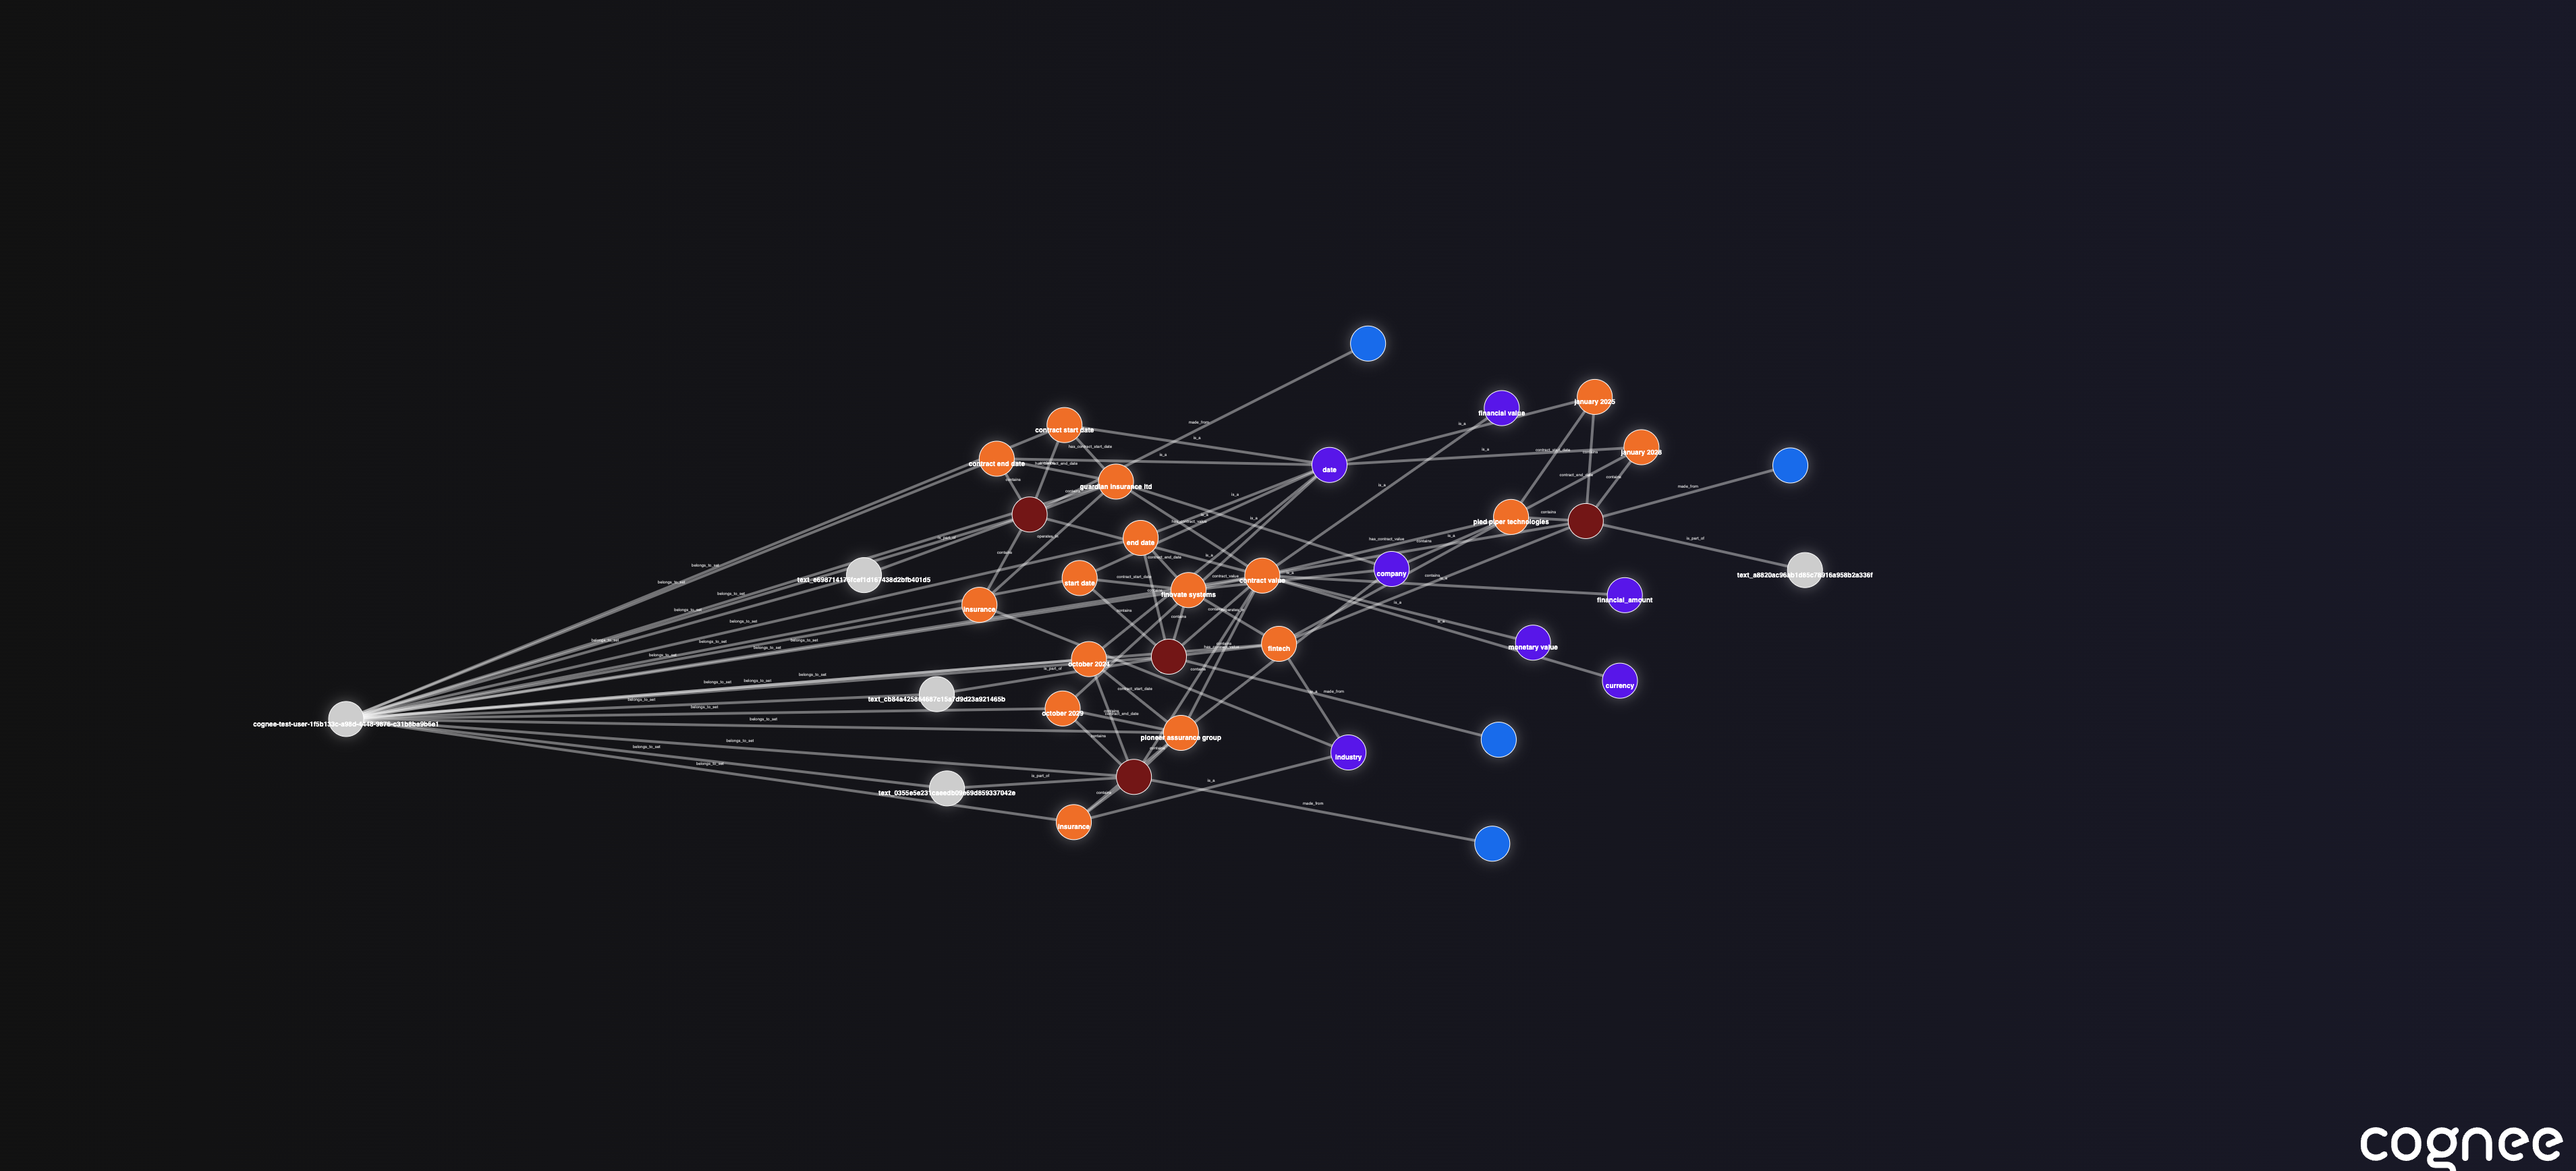

In [25]:
from IPython.display import Image, display

display(Image(filename="./images/sessionised_graph_screenshot.png"))

You can see clearly two groups of data.
1. Our session identifier unites around itself all the input that was processed within that session
2. Other newly added information distinctly stands out from that group of nodes to the right